# Script to make simu
This script run the model from a restart to produce a reference simulation for training or testing the NN.

In [1]:
## Import package
from neuralsw.model.shalw import SWmodel
from neuralsw.model.datatools import TimeSeq 
import neuralsw
import numpy as np
import xarray as xr
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook


In [2]:
## Specify the output
PLOT = True #if plot is wanted

#rootdir
rootdir = os.path.realpath(\
	os.path.join(os.getcwd(),'../..'))

#directory to store the data
datadir = os.path.realpath(os.path.join(rootdir,'data'))


#Duration of the integration
endtime = 48*30*12*40 #40 years (can be override by option in allsets)

#save frequency
freq = 48*30 #each month (can be overrieded by option in allsets)

#number of successive time steps to save at a given time
nseq = 2

#param to save
param = {'hphy','uphy','vphy','taux','tauy','uparam','vparam'}
print('data directory:',datadir)


data directory: /Users/brajard/Documents/recherche/collaboration/bigdata/shallownn/data


## Option in allsets
### Mandatory:
- `'suf'`: suffix of the simu filename
- `'type'`: prefix of the simul filename (defined the type of set train/test/valid
- `'rst'`: restart file to initialize the model (generate by `restart` script)

### Optional:
-  `'saverst'`: save a restart file at the end of the simu
-  `'endtime'`: change the default value for the end of the simu
-  `'freq'`: change the default frequency of save
- `'warg'`: specify forcing args in the SW model 

In [3]:
## Specifiy types of dataset to run

warg0 = {'sigx':0.1} #a example of forcing arg
warg1 = {'sigx':0.1,'arx':0.6,'convx':5}

#restartfile for app
rstfile = os.path.join(datadir,'restart_10years.nc')

#restartfile for test
rstfile_test = os.path.join(datadir,'restart_test.nc')

##############################################################
# SPECIFY THE TYPE OF DATASET TO BE GENEREATED (SEE ABOVE)   #
##############################################################
allsets = {0:{'suf':'std','type':'train','rst':rstfile,'saverst':rstfile_test},
           1:{'suf':'windvar','type':'test','endtime':48*30*12*10,'warg':warg0,'rst':rstfile_test},
           2:{'suf':'warsmooth','type':'test','endtime':48*30*12*10,'warg':warg1,'rst':rstfile_test},
           3:{'suf':'std','type':'test','endtime':48*30*12*10,'rst':rstfile_test}}

selected = 0 #to be change to create more sets
###############################################################
           
dset = allsets[selected]

#filename
fname = os.path.join(datadir,dset['type']+'_dataset_'+dset['suf']+'.nc')

print('filename:',fname)

filename: /Users/brajard/Documents/recherche/collaboration/bigdata/shallownn/data/train_dataset_std.nc


In [4]:
## redefine some options
if 'endtime' in dset:
    endtime = dset['endtime']
if 'freq' in dset:
    freq = dset['freq']
if 'nseq' in dset:
    nseq = dset['nseq']
if 'warg' in dset:
    warg = dset['warg']
else:
    warg = dict()

In [5]:
## Init model for training set
SW = SWmodel(nx=80,ny=80,warg=warg)
SW.inistate_rst(rstfile)
SW.set_time(0)

#time
time = TimeSeq(endtime=endtime,freq=freq,start=0,nseq=nseq)

#Save every freq
SW.save(time=time,name=fname,para=param)

In [6]:
# run the model for training set
for i in tqdm(range(endtime)):
    SW.next()

100%|██████████| 691200/691200 [24:55<00:00, 462.09it/s]


In [7]:
# Save the restart for test set
if 'saverst' in dset:
    SW.save_rst(dset['saverst'])


/Users/brajard/anaconda/envs/nn/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<IPython.core.display.Javascript object>


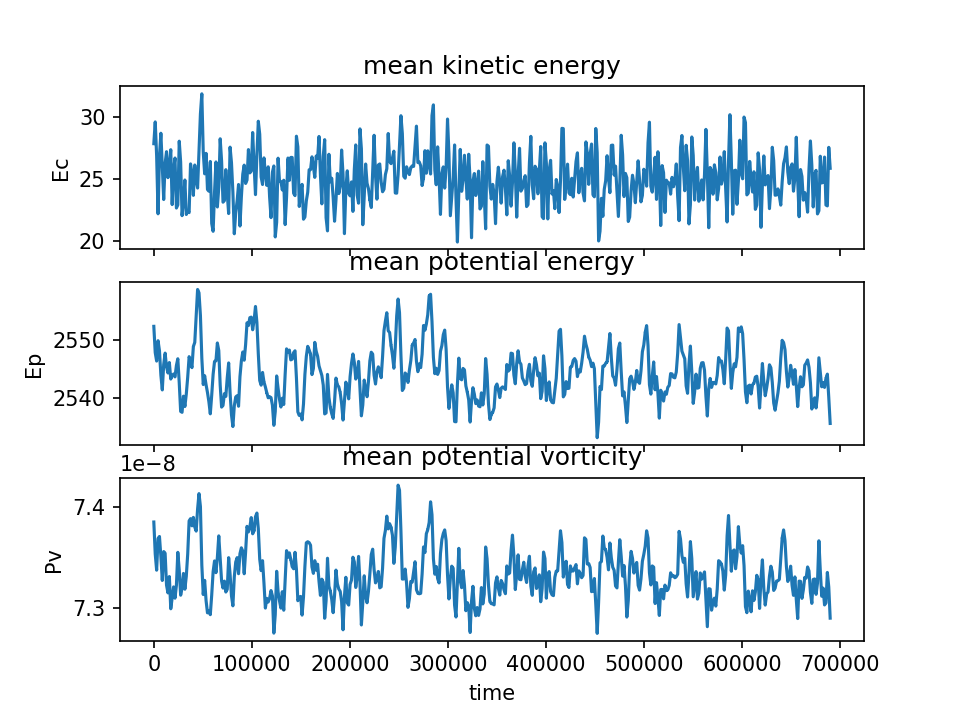

Mean value of Ec: 2.51e+01
Mean value of Ep: 2.54e+03
Mean value of Pv: 7.33e-08


In [8]:
## Plots conservative quantities for training set
if PLOT:
    import neuralsw.model.modeltools as model

    ds = xr.open_dataset(fname)

    fig,ax = plt.subplots(nrows=3,sharex=True)
    Ec = model.cinetic_ener(ds=ds)
    Ep = model.potential_ener(ds=ds)
    Pv = model.potential_vor(ds=ds)
    Ec.plot(ax=ax[0])
    Ep.plot(ax=ax[1])
    Pv.plot(ax=ax[2])
    ax[0].set_title('mean kinetic energy')
    ax[0].set_ylabel('Ec')
    ax[0].set_xlabel('')
    ax[1].set_title('mean potential energy')
    ax[1].set_ylabel('Ep')
    ax[1].set_xlabel('')
    ax[2].set_title('mean potential vorticity')
    ax[2].set_ylabel('Pv')
    plt.show()
    print ('Mean value of Ec: {0:3.2e}'.format(float(Ec.mean())))
    print ('Mean value of Ep: {0:3.2e}'.format(float(Ep.mean())))
    print ('Mean value of Pv: {0:3.2e}'.format(float(Pv.mean())))

<IPython.core.display.Javascript object>


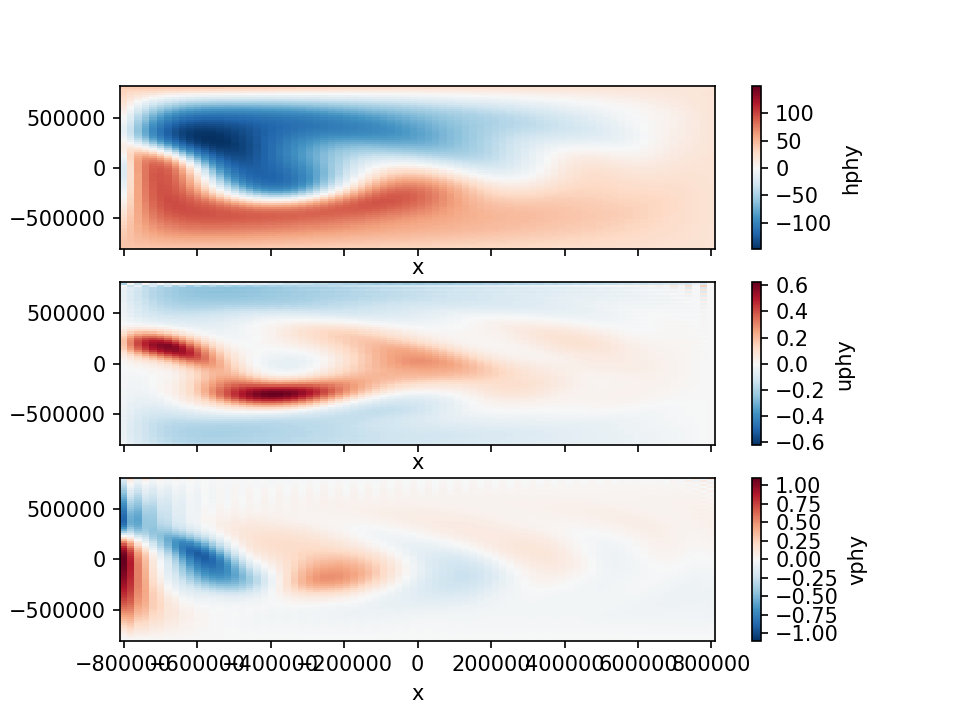

<IPython.core.display.Javascript object>


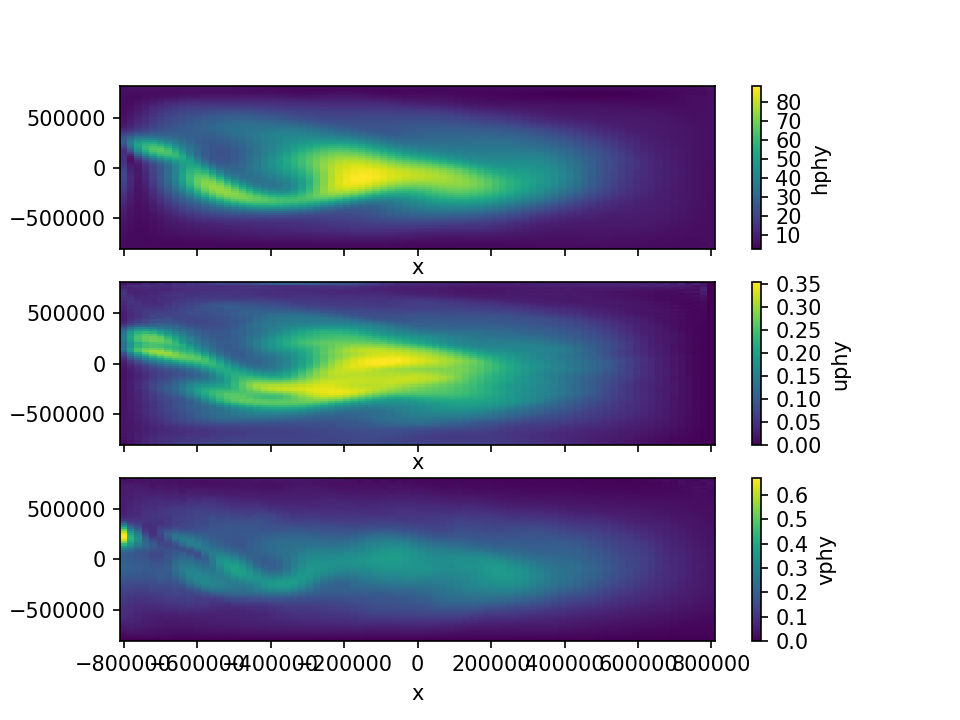

In [9]:
## Plots mean states for training
if PLOT:
    ds = xr.open_dataset(fname)

    fig,ax = plt.subplots(nrows=3,sharex=True)
    ds['hphy'].mean(dim='time').plot(ax=ax[0])
    ds['uphy'].mean(dim='time').plot(ax=ax[1])
    ds['vphy'].mean(dim='time').plot(ax=ax[2])

    plt.show()
    
    fig,ax = plt.subplots(nrows=3,sharex=True)
    ds['hphy'].std(dim='time').plot(ax=ax[0])
    ds['uphy'].std(dim='time').plot(ax=ax[1])
    ds['vphy'].std(dim='time').plot(ax=ax[2])

    plt.show()
    
    